## Libraries and modules

In [74]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import Counter
from matplotlib.pyplot import pie, axis, show
from sklearn import preprocessing
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
df = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

In [3]:
print ("Sample training data:", len(df))
df.head()

Sample training data: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print ("Sample test data:", len(dftest))
dftest.head()

Sample test data: 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data munging

Feature 'Ticket', 'Fare' and 'Cabin' are dropped since they are correlated to 'Class'. Feature 'Name' is also dropped.

In [5]:
dfcleancsv = pd.concat([df['PassengerId'], df['Pclass'], df['Sex'], df['Age'], df['SibSp'], df['Parch'], df['Embarked'], df['Survived']], axis=1)

dftestcleancsv = pd.concat([dftest['PassengerId'], dftest['Pclass'], dftest['Sex'], dftest['Age'], dftest['SibSp'], dftest['Parch'], dftest['Embarked']], axis=1)
dftestcleancsv["Survived"] = ""

In [6]:
print ("Training data:", len(dfcleancsv))
dfcleancsv.head()

Training data: 891


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,1,3,male,22.0,1,0,S,0
1,2,1,female,38.0,1,0,C,1
2,3,3,female,26.0,0,0,S,1
3,4,1,female,35.0,1,0,S,1
4,5,3,male,35.0,0,0,S,0


In [67]:
print ("Test data:", len(dftestcleancsv))
dftestcleancsv.head()

Test data: 418


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,892,3,male,34.5,0,0,Q,
1,893,3,female,47.0,1,0,S,
2,894,2,male,62.0,0,0,Q,
3,895,3,male,27.0,0,0,S,
4,896,3,female,22.0,1,1,S,


In [7]:
# Check survival distribution
print ("Survival distribution (0 = Non survive, 1 = Survive):")
print (dfcleancsv['Survived'].value_counts())
print ("Percent survive", dfcleancsv.Survived.value_counts()[1]/len(dfcleancsv))
print ("Percent non survive", dfcleancsv.Survived.value_counts()[0]/len(dfcleancsv))

Survival distribution (0 = Non survive, 1 = Survive):
0    549
1    342
Name: Survived, dtype: int64
Percent survive 0.3838383838383838
Percent non survive 0.6161616161616161


In [8]:
#Check for missing values
def  na_count(df, dataset):
    counter = 0
    for i in range(len(df.columns)):
        na_count = df.iloc[:,i].isnull().sum()
        if na_count >= 1:
            print ('{} Feature {} has {} missing value(s)'.format(dataset, df.columns[i],str(na_count)))
            counter += 1
    if counter == 0:
        print ('No column has NA in {}'.format(dataset))
        
na_count(pd.DataFrame(dfcleancsv), "Training Data:")
na_count(pd.DataFrame(dftestcleancsv), "Test Data:")

Training Data: Feature Age has 177 missing value(s)
Training Data: Feature Embarked has 2 missing value(s)
Test Data: Feature Age has 86 missing value(s)


Checking the 'Age' distribution in training data set

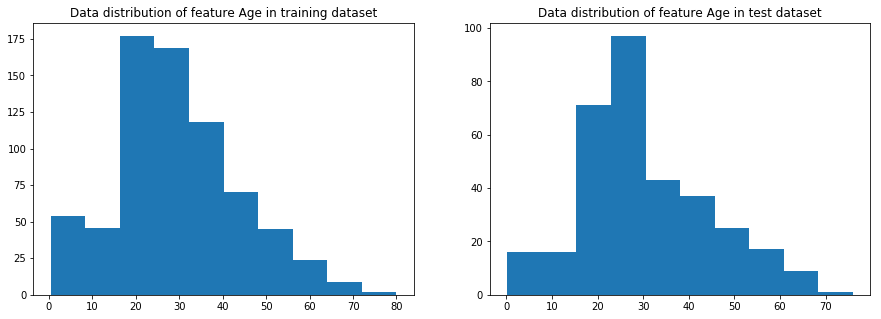

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].hist(dfcleancsv['Age'].dropna())
ax[0].set_title('Data distribution of feature Age in training dataset')

ax[1].hist(dftestcleancsv['Age'].dropna())
ax[1].set_title('Data distribution of feature Age in test dataset')

plt.show()

Since the age distribution is normal, the missing values will be replaced with the mean of age.

In [10]:
dfcleancsv['Age'] = dfcleancsv['Age'].fillna(dfcleancsv['Age'].mean())
dftestcleancsv['Age'] = dftestcleancsv['Age'].fillna(dftestcleancsv['Age'].mean())
na_count(dfcleancsv, "Training Data")
na_count(dftestcleancsv, "Test Data")

Training Data Feature Embarked has 2 missing value(s)
No column has NA in Test Data


Checking the new 'Age' distribution

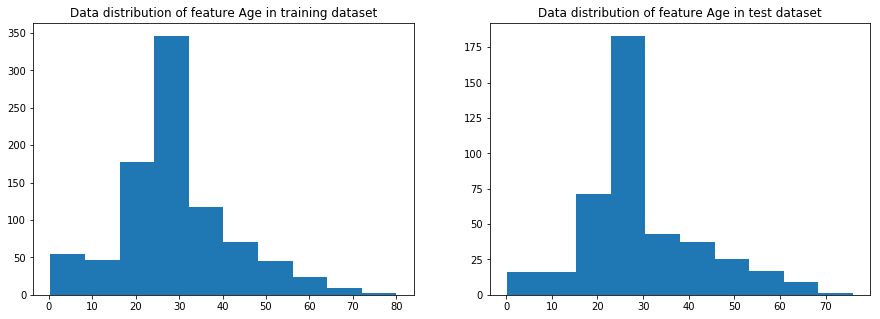

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].hist(dfcleancsv['Age'].dropna())
ax[0].set_title('Data distribution of feature Age in training dataset')

ax[1].hist(dftestcleancsv['Age'].dropna())
ax[1].set_title('Data distribution of feature Age in test dataset')

plt.show()

Checking the percentage of survival based on place of embark

In [12]:
embark = dfcleancsv.Embarked.value_counts()
dfembark = pd.DataFrame({'Embarked':embark.index, 'Total':embark.values})

embark_survive = dfcleancsv.Survived.groupby(dfcleancsv.Embarked).sum()
dfembark_survive = pd.DataFrame({'Embarked':embark_survive.index, 'Survived':embark_survive.values})

percentembark_survive = pd.merge(dfembark, dfembark_survive, on='Embarked').sort_values(by=['Embarked'])

percentembark_survive['Percent Survive'] = percentembark_survive['Survived']/percentembark_survive['Total']
print (percentembark_survive)

  Embarked  Total  Survived  Percent Survive
1        C    168        93         0.553571
2        Q     77        30         0.389610
0        S    644       217         0.336957


Checking the survival of passenger with no 'Embarked' data

In [13]:
dfcleancsv[dfcleancsv.isnull().any(axis=1)]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
61,62,1,female,38.0,0,0,NaN,1
829,830,1,female,62.0,0,0,NaN,1


Since the rate of survival of passengers embarked from 'C' is more than 50% and both passengers with no 'Embarked' data survived, the missing values of 'Embarked' will be replaced by' C'

In [14]:
dfcleancsv['Embarked'] = dfcleancsv['Embarked'].fillna('C')
na_count(dfcleancsv, "Training Data")

No column has NA in Training Data


It can be seen that the percent survival distribution is not significantly changed after the missing values replacement.

In [15]:
embark = dfcleancsv.Embarked.value_counts()
dfembark = pd.DataFrame({'Embarked':embark.index, 'Total':embark.values})

embark_survive = dfcleancsv.Survived.groupby(dfcleancsv.Embarked).sum()
dfembark_survive = pd.DataFrame({'Embarked':embark_survive.index, 'Survived':embark_survive.values})

percentembark_survive = pd.merge(dfembark, dfembark_survive, on='Embarked').sort_values(by=['Embarked'])

percentembark_survive['Percent Survive'] = percentembark_survive['Survived']/percentembark_survive['Total']
print (percentembark_survive)

  Embarked  Total  Survived  Percent Survive
1        C    170        95         0.558824
2        Q     77        30         0.389610
0        S    644       217         0.336957


In [16]:
# Categorizing 'SibSp' and 'Parch' to 0 or 1
dfcleancsv['SibSp'] = dfcleancsv['SibSp'].replace([1,2,3,4,5,6,7,8], 1)
dftestcleancsv['SibSp'] = dftestcleancsv['SibSp'].replace([1,2,3,4,5,6,7,8], 1)

dfcleancsv['Parch'] = dfcleancsv['Parch'].replace([1,2,3,4,5,6], 1)
dftestcleancsv['Parch'] = dftestcleancsv['Parch'].replace([1,2,3,4,5,6,7,8], 1)

Normalise and encode data

In [17]:
# Encode 'Sex' and 'Embarked' values
val_code = LabelEncoder()

#Training data
dfcleancsv['Sex'] = val_code.fit_transform(dfcleancsv['Sex'])
dfcleancsv['Embarked'] = val_code.fit_transform(dfcleancsv['Embarked'])

#Test data
dftestcleancsv['Sex'] = val_code.fit_transform(dftestcleancsv['Sex'])
dftestcleancsv['Embarked'] = val_code.fit_transform(dftestcleancsv['Embarked'])


In [18]:
# Normalize and scale 'Age'
dfcleancsv["Age"] = dfcleancsv["Age"] / dfcleancsv["Age"].max()
dftestcleancsv["Age"] = dftestcleancsv["Age"] / dftestcleancsv["Age"].max()


In [19]:
dfcleancsv.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,1,3,1,0.2750,1,0,2,0
1,2,1,0,0.4750,1,0,0,1
2,3,3,0,0.3250,0,0,2,1
3,4,1,0,0.4375,1,0,2,1
4,5,3,1,0.4375,0,0,2,0


In [20]:
dftestcleancsv.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,892,3,1,0.453947,0,0,1,
1,893,3,0,0.618421,1,0,2,
2,894,2,1,0.815789,0,0,1,
3,895,3,1,0.355263,0,0,2,
4,896,3,0,0.289474,1,1,2,


## Model Building

In [79]:
#Create the training/validation data and labels
Xtrain = dfcleancsv.iloc[0:,1:7]
ytrain = dfcleancsv.iloc[0:,7:]

train_X, val_X, train_y, val_y = train_test_split(Xtrain, ytrain, test_size=0.3)

#For results
classifier_r = []
parameters_r = []
accuracy_r = []

K-NN

In [80]:
def plot_estimator(estimator, X, y):
    '''
    This function takes a model (estimator), 
    '''
    estimator.fit(X, y)
    # Determine the maximum and minimum mesh as a boundary
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    # Generating the points on the mesh
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Make predictions on the grid points
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # for color
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Original training sample
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

start_time = time.time()
print("Running ...")
print 
k_val = []
acc = []
print ("\tK\t\tAccuracy")

# Build a kNN using 1-50 neighbour nodes
for i in range(1,51):
    k_val.append(i)
    knn_model = KNeighborsClassifier(n_neighbors=i)
    y_pred = cross_val_predict(knn_model, train_X, train_y, cv=10)
    knn_accuracy = accuracy_score(train_y, y_pred)
    acc.append(knn_accuracy)
    print ("\t{:f}\t{:f}".format(i, knn_accuracy))

print("="*40)
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))

print ("The best accuracy score is {}". format(max(acc)))
idx = acc.index(max(acc))
best_K = k_val[idx]
print ("The best K is {}".format(best_K))

classifier_r.append("K-NN")
parameters_r.append("No. of neighbours = {}".format(best_K))
accuracy_r.append(max(acc))

Running ...
	K		Accuracy
	1.000000	0.746388
	2.000000	0.767255
	3.000000	0.765650
	4.000000	0.768860
	5.000000	0.764045
	6.000000	0.786517
	7.000000	0.788122
	8.000000	0.808989
	9.000000	0.797753
	10.000000	0.808989
	11.000000	0.802568
	12.000000	0.818620
	13.000000	0.812199
	14.000000	0.810594
	15.000000	0.805778
	16.000000	0.810594
	17.000000	0.807384
	18.000000	0.807384
	19.000000	0.804173
	20.000000	0.813804
	21.000000	0.808989
	22.000000	0.812199
	23.000000	0.813804
	24.000000	0.815409
	25.000000	0.812199
	26.000000	0.812199
	27.000000	0.813804
	28.000000	0.808989
	29.000000	0.807384
	30.000000	0.799358
	31.000000	0.794543
	32.000000	0.789727
	33.000000	0.789727
	34.000000	0.792937
	35.000000	0.783307
	36.000000	0.788122
	37.000000	0.781701
	38.000000	0.784912
	39.000000	0.788122
	40.000000	0.786517
	41.000000	0.778491
	42.000000	0.778491
	43.000000	0.780096
	44.000000	0.775281
	45.000000	0.778491
	46.000000	0.780096
	47.000000	0.783307
	48.000000	0.780096
	49.000000	0.778491
	50.

Logistic Regression with Elastic Net

In [81]:
alpha_val = [1e-4,3e-4,1e-3,3e-3,1e-2,3e-2]
l1 = [0,0.15,0.5,0.7,1]

alpha_ = []
l1_ = []
acc = []
print("Running ...")
print 

print ("\tAlpha\t\tL1 Ratio\tAccuracy")

for i in range(len(alpha_val)):
    for j in l1:
        enet = SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha_val[i], l1_ratio=j) 
        enet.fit(train_X, train_y)
        y_pred = enet.predict(train_X)
        enet_acc = accuracy_score(y_pred, train_y)
        y_pred = cross_val_predict(enet, train_X, train_y, cv=10)
        en_accuracy = accuracy_score(train_y, y_pred)
        alpha_.append(alpha_val[i])
        l1_.append(j)
        acc.append(en_accuracy)
        print ("\t{:f}\t{:f}\t{:f}".format(alpha_val[i],j, en_accuracy))

print("="*40)
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))

print ("The best accuracy score is {}". format(max(acc)))
idx = acc.index(max(acc))
best_alpha = alpha_[idx]
best_l1 = l1_[idx]
print ("The best parameters are alpha={}, l1={}".format(best_alpha, best_l1))

classifier_r.append("EN")
parameters_r.append("Alpha={}, L1={}".format(best_alpha, best_l1))
accuracy_r.append(max(acc))

Running ...
	Alpha		L1 Ratio	Accuracy
	0.000100	0.000000	0.723917
	0.000100	0.150000	0.731942
	0.000100	0.500000	0.719101
	0.000100	0.700000	0.757624
	0.000100	1.000000	0.759230
	0.000300	0.000000	0.690209
	0.000300	0.150000	0.723917
	0.000300	0.500000	0.723917
	0.000300	0.700000	0.685393
	0.000300	1.000000	0.762440
	0.001000	0.000000	0.765650
	0.001000	0.150000	0.746388
	0.001000	0.500000	0.701445
	0.001000	0.700000	0.776886
	0.001000	1.000000	0.701445
	0.003000	0.000000	0.773676
	0.003000	0.150000	0.760835
	0.003000	0.500000	0.791332
	0.003000	0.700000	0.768860
	0.003000	1.000000	0.776886
	0.010000	0.000000	0.781701
	0.010000	0.150000	0.797753
	0.010000	0.500000	0.751204
	0.010000	0.700000	0.767255
	0.010000	1.000000	0.760835
	0.030000	0.000000	0.780096
	0.030000	0.150000	0.786517
	0.030000	0.500000	0.772071
	0.030000	0.700000	0.791332
	0.030000	1.000000	0.789727
--- Running time: 10.63218092918396 seconds ---
The best accuracy score is 0.797752808988764
The best parameters are alpha

Support Vector Machine with RBF

In [82]:
g = [1e-3, 1e-4]
C = [1, 10, 100, 1000]

gamma_ = []
c_val = []
acc = []
print("Running ...")
print 

print ("\tGamma\t\tC value\t\tAccuracy")

for i in range(len(g)):
    for j in C:
        svc = svm.SVC(C=j, kernel='rbf', gamma=g[i]) 
        y_pred = cross_val_predict(svc, train_X, train_y, cv=10)
        svm_accuracy = accuracy_score(train_y, y_pred)
        gamma_.append(g[i])
        c_val.append(j)
        acc.append(svm_accuracy)
        print ("\t{:f}\t{:f}\t\t{:f}".format(g[i],j, svm_accuracy))

print("="*40)
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))

print ("The best accuracy score is {}". format(max(acc)))
idx = acc.index(max(acc))
best_gamma = gamma_[idx]
best_C = c_val[idx]
print ("The best parameters are gamma={}, C={}".format(best_gamma, best_C))

classifier_r.append("SVM")
parameters_r.append("Gamma={} C={}".format(best_gamma, best_C))
accuracy_r.append(max(acc))

Running ...
	Gamma		C value		Accuracy
	0.001000	1.000000		0.617978
	0.001000	10.000000		0.784912
	0.001000	100.000000		0.784912
	0.001000	1000.000000		0.784912
	0.000100	1.000000		0.617978
	0.000100	10.000000		0.617978
	0.000100	100.000000		0.784912
	0.000100	1000.000000		0.784912
--- Running time: 16.492515802383423 seconds ---
The best accuracy score is 0.7849117174959872
The best parameters are gamma=0.001, C=10


Random Forest

In [83]:
depth = [10,100,300,500]
trees = [50,100,200,500]

depth_ = []
trees_ = []
acc = []

print("Running ...")
print 

print ("\tDepth\t\tNo. of Trees\tAccuracy")

for i in range(len(depth)):
    for j in trees:
        rfclf = RandomForestClassifier(n_estimators=j, max_depth=depth[i], random_state=42)
        y_pred = cross_val_predict(rfclf, train_X, train_y, cv=10)
        rf_accuracy = accuracy_score(train_y, y_pred)
        depth_.append(depth[i])
        trees_.append(j)
        acc.append(rf_accuracy)
        print ("\t{:f}\t{:f}\t{:f}".format(depth[i],j, rf_accuracy))
        
print("="*40)
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))

print ("The best accuracy score is {}". format(max(acc)))
idx = acc.index(max(acc))
best_depth = depth_[idx]
best_trees = trees_[idx]
print ("The best parameters are tree depth={} with no. of trees={}".format(best_depth, best_trees))

classifier_r.append("RF")
parameters_r.append("Depth={} Trees={}".format(best_depth, best_trees))
accuracy_r.append(max(acc))

Running ...
	Depth		No. of Trees	Accuracy
	10.000000	50.000000	0.800963
	10.000000	100.000000	0.800963
	10.000000	200.000000	0.796148
	10.000000	500.000000	0.794543
	100.000000	50.000000	0.794543
	100.000000	100.000000	0.792937
	100.000000	200.000000	0.794543
	100.000000	500.000000	0.796148
	300.000000	50.000000	0.794543
	300.000000	100.000000	0.792937
	300.000000	200.000000	0.794543
	300.000000	500.000000	0.796148
	500.000000	50.000000	0.794543
	500.000000	100.000000	0.792937
	500.000000	200.000000	0.794543
	500.000000	500.000000	0.796148
--- Running time: 79.66973185539246 seconds ---
The best accuracy score is 0.8009630818619583
The best parameters are tree depth=10 with no. of trees=50


Summary - the best classifier

In [89]:
print ("\tClassifier\tBest parameters\t\t Validation Accuracy")
for i in range(len(classifier_r)):
    print ("\t{:s}\t\t{:s}\t\t{:f}".format(classifier_r[i], parameters_r[i], accuracy_r[i]))
print 
idx = accuracy_r.index(max(accuracy_r))
idx_ = accuracy_r.index(min(accuracy_r))
print ('The best validation accuracy is {} where {} classifier is used with {}.'.format(max(accuracy_r), classifier_r[idx], parameters_r[idx]))
print 
print ('The worst performing classifier is {} with {} which gave validation accuracy value of {}.'. format(classifier_r[idx_],  parameters_r[idx_], min(accuracy_r)))


	Classifier	Best parameters		 Validation Accuracy
	K-NN		No. of neighbours = 12		0.818620
	EN		Alpha=0.01, L1=0.15		0.797753
	SVM		Gamma=0.001 C=10		0.784912
	RF		Depth=10 Trees=50		0.800963
The best validation accuracy is 0.8186195826645265 where K-NN classifier is used with No. of neighbours = 12.
The worst performing classifier is SVM with Gamma=0.001 C=10 which gave validation accuracy value of 0.7849117174959872.


Predicting the survival of passengers listed in test data

In [115]:
p_id = dftestcleancsv.iloc[0:,0:1]
p_id = np.array(p_id.iloc[:, 0].tolist())

In [116]:
Xtest = dftestcleancsv.iloc[0:,1:7]

knn_model = KNeighborsClassifier(n_neighbors=best_K)
knn_model.fit(Xtrain, ytrain)
y_pred = knn_model.predict(Xtest)


Saving into the required format

In [117]:
pred_df = pd.DataFrame({"PassengerId" : p_id, "Survived" : y_pred})
pred_df.to_csv("submission.csv", index=False)